In [6]:
# Standard libraries
import os
import random
import numpy as np

# PyTorch and related
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

# Misc
from tqdm import tqdm

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Define transformations
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

# Clean test data
transform_test_clean = transforms.Compose([
    transforms.ToTensor(),
])

# Domain-shifted test data (simulating shift: brightness, contrast, blur, etc.)
transform_test_shifted = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

# Load CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset_clean = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_clean)
testset_shifted = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_shifted)

# Dataloaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader_clean = DataLoader(testset_clean, batch_size=128, shuffle=False, num_workers=2)
testloader_shifted = DataLoader(testset_shifted, batch_size=128, shuffle=False, num_workers=2)

# Class names
classes = trainset.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


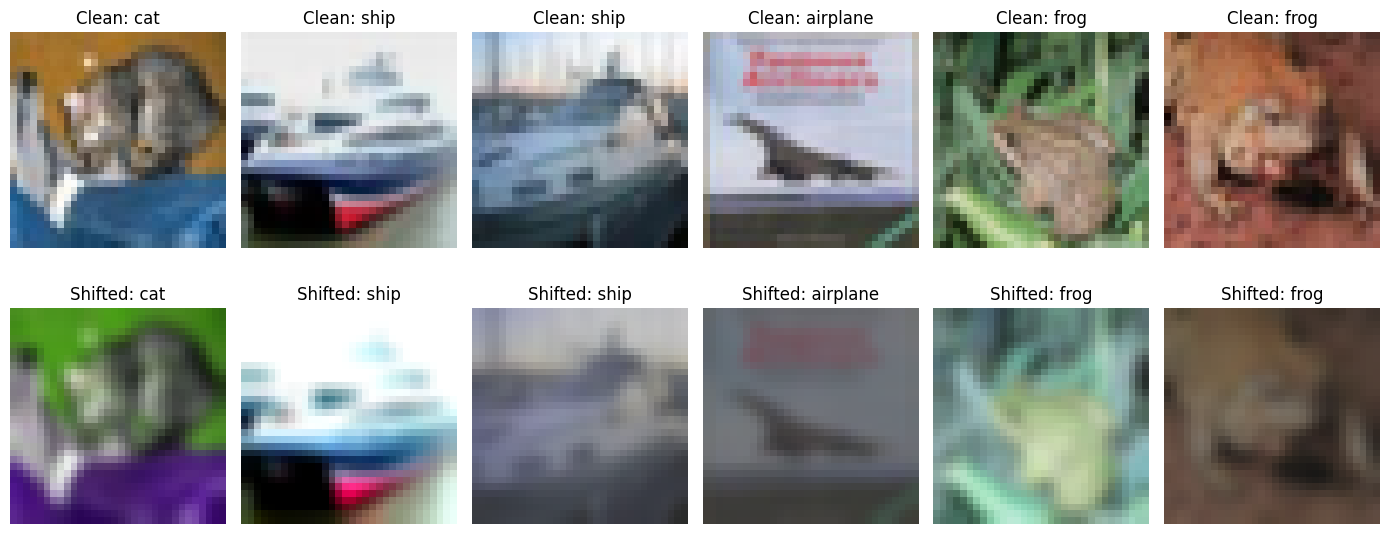

In [8]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of clean images
clean_images, clean_labels = next(iter(testloader_clean))
shifted_images, shifted_labels = next(iter(testloader_shifted))

# Plot
plt.figure(figsize=(14, 6))
for i in range(6):
    # Clean image
    plt.subplot(2, 6, i + 1)
    imshow(clean_images[i])
    plt.title(f"Clean: {classes[clean_labels[i]]}")
    
    # Shifted image
    plt.subplot(2, 6, i + 7)
    imshow(shifted_images[i])
    plt.title(f"Shifted: {classes[shifted_labels[i]]}")

plt.tight_layout()
plt.show()

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: [3, 32, 32]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # Output: [32, 16, 16]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # Output: [64, 8, 8]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # Output: [128, 4, 4]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model and move to device
model = SimpleCNN(num_classes=10).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropou

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, trainloader, testloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Stats
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        print(f"[{epoch+1}] Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Train the model
train_model(model, trainloader, testloader_clean, criterion, optimizer, epochs=10)

# Save the model
os.makedirs("og_Model", exist_ok=True)
torch.save(model.state_dict(), "og_Model/trustnet_cnn.pth")

[1] Loss: 1.2375, Accuracy: 55.80%


[2] Loss: 0.8490, Accuracy: 70.29%


[3] Loss: 0.6907, Accuracy: 75.76%


[4] Loss: 0.5835, Accuracy: 79.45%


[5] Loss: 0.4943, Accuracy: 82.50%


[6] Loss: 0.4159, Accuracy: 85.21%


[7] Loss: 0.3587, Accuracy: 87.21%


[8] Loss: 0.3072, Accuracy: 89.07%


[9] Loss: 0.2734, Accuracy: 90.22%


[10] Loss: 0.2335, Accuracy: 91.62%


For each prediction, compute the **entropy** of the softmax output as a confidence score.

Entropy is defined as:

H(p)=−∑ipi⋅log⁡(pi)H(p) = -\sum_i p_i \cdot \log(p_i)

- **Low entropy** → high confidence
- **High entropy** → low confidence / uncertainty
    
    We'll use this to analyze the trust level of predictions.

In [7]:
def compute_entropy(logits):
    """
    Computes entropy for each prediction in a batch.
    Input: logits (before softmax), shape [batch_size, num_classes]
    Output: entropy scores, shape [batch_size]
    """
    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)
    entropy = -torch.sum(probs * log_probs, dim=1)
    return entropy

In [8]:
def evaluate_with_entropy(model, dataloader):
    model.eval()
    all_preds, all_labels, all_entropy, all_correct = [], [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Predictions and entropy
            entropy = compute_entropy(outputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_entropy.extend(entropy.cpu().numpy())
            all_correct.extend((preds == labels).cpu().numpy())

    return {
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "entropy": np.array(all_entropy),
        "correct": np.array(all_correct)
    }

# Evaluate on clean and shifted sets
result_clean = evaluate_with_entropy(model, testloader_clean)
result_shifted = evaluate_with_entropy(model, testloader_shifted)

Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


📈 1. Accuracy on Clean vs Shifted

In [9]:
acc_clean = np.mean(result_clean["preds"] == result_clean["labels"])
acc_shifted = np.mean(result_shifted["preds"] == result_shifted["labels"])

print(f"✅ Clean Accuracy: {acc_clean*100:.2f}%")
print(f"⚠️  Shifted Accuracy: {acc_shifted*100:.2f}%")

✅ Clean Accuracy: 77.50%
⚠️  Shifted Accuracy: 54.15%


📉 2. Entropy Distribution Plot

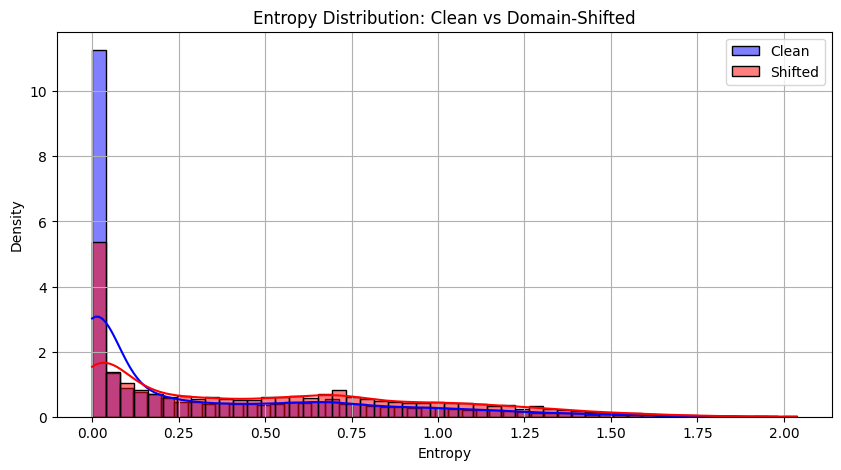

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(result_clean["entropy"], bins=50, color='blue', label='Clean', stat='density', kde=True)
sns.histplot(result_shifted["entropy"], bins=50, color='red', label='Shifted', stat='density', kde=True)
plt.title("Entropy Distribution: Clean vs Domain-Shifted")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

✅ 3. Entropy: Correct vs Incorrect Predictions

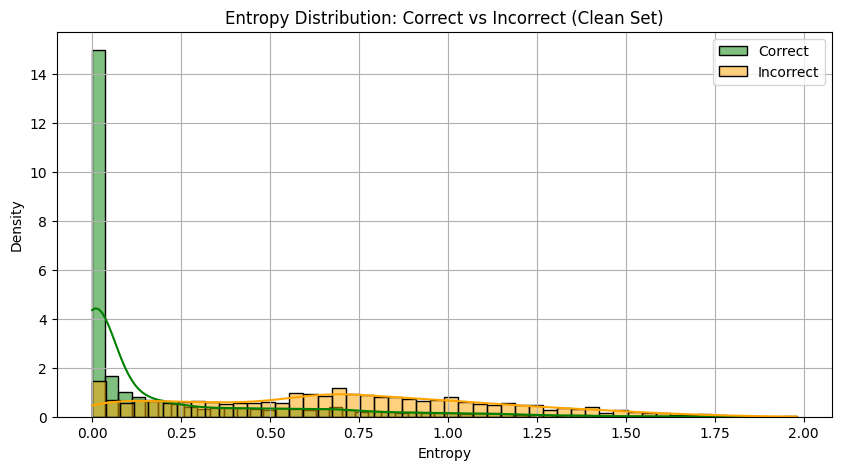

In [11]:
correct_entropy = result_clean["entropy"][result_clean["correct"] == 1]
incorrect_entropy = result_clean["entropy"][result_clean["correct"] == 0]

plt.figure(figsize=(10, 5))
sns.histplot(correct_entropy, bins=50, color='green', label='Correct', stat='density', kde=True)
sns.histplot(incorrect_entropy, bins=50, color='orange', label='Incorrect', stat='density', kde=True)
plt.title("Entropy Distribution: Correct vs Incorrect (Clean Set)")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

🧪 4. ROC Curve: Can Entropy Detect OOD?

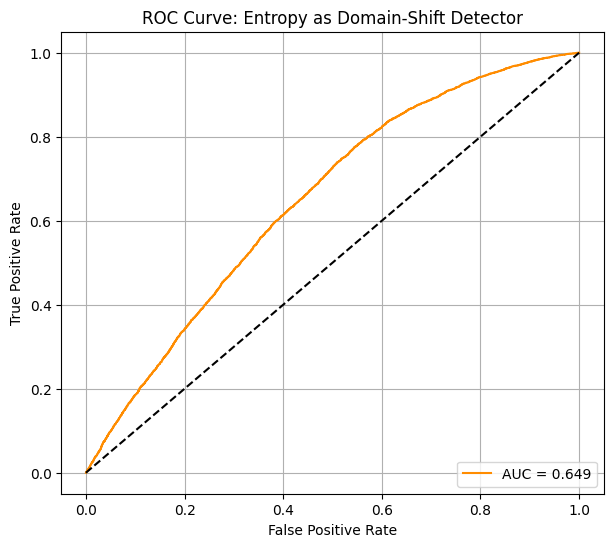

In [12]:
from sklearn.metrics import roc_curve, auc

# Labels: 0 for clean, 1 for shifted
y_true = np.concatenate([np.zeros_like(result_clean["entropy"]),
                         np.ones_like(result_shifted["entropy"])])
y_score = np.concatenate([result_clean["entropy"], result_shifted["entropy"]])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: Entropy as Domain-Shift Detector")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

🔧 Step 7: Advanced Additions for Uncertainty & OOD Detection

In [11]:
def odin_predict(model, inputs, epsilon=0.0014, temperature=1000):
    inputs = inputs.clone().detach().to(device).requires_grad_(True)
    
    # Forward pass
    outputs = model(inputs)
    outputs = outputs / temperature
    
    # Compute gradient w.r.t max logit
    max_logit, pred_label = torch.max(outputs, dim=1)
    loss = -torch.mean(max_logit)
    model.zero_grad()
    loss.backward()
    
    # Perturb inputs
    gradient = torch.sign(inputs.grad.data)
    perturbed_inputs = inputs - epsilon * gradient
    perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)
    
    # Forward again with perturbed inputs
    outputs = model(perturbed_inputs)
    outputs = outputs / temperature
    softmax_outputs = F.softmax(outputs, dim=1)
    return softmax_outputs

In [12]:
def evaluate_with_odin(model, dataloader, epsilon=0.0014, temperature=1000):
    model.eval()
    all_entropy = []
    all_preds = []
    all_labels = []
    all_correct = []

    for inputs, labels in tqdm(dataloader, desc="Evaluating ODIN"):
        # 🚫 Don't disable grad here — ODIN needs gradients
        softmax_outputs = odin_predict(model, inputs, epsilon, temperature)

        # Now you can safely disable grad if you're doing further processing
        with torch.no_grad():
            entropy = -torch.sum(softmax_outputs * torch.log(softmax_outputs + 1e-12), dim=1)
            preds = torch.argmax(softmax_outputs, dim=1)

            all_entropy.extend(entropy.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_correct.extend((preds.cpu() == labels).numpy())

    return {
        "entropy": np.array(all_entropy),
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "correct": np.array(all_correct)
    }

In [13]:
result_clean_odin = evaluate_with_odin(model, testloader_clean)
result_shifted_odin = evaluate_with_odin(model, testloader_shifted)

Evaluating ODIN: 100%|██████████| 79/79 [00:23<00:00,  3.40it/s]


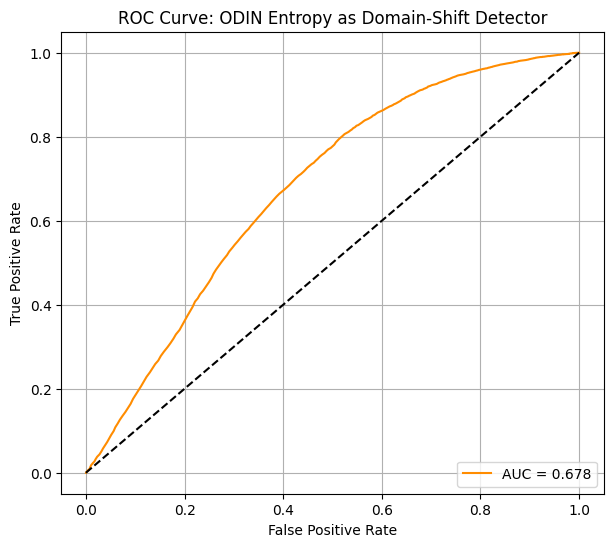

In [14]:
# Show ROC curve for ODIN
y_true_odin = np.concatenate([np.zeros_like(result_clean_odin["entropy"]),
                                np.ones_like(result_shifted_odin["entropy"])])
y_score_odin = np.concatenate([result_clean_odin["entropy"], result_shifted_odin["entropy"]])
fpr_odin, tpr_odin, _ = roc_curve(y_true_odin, y_score_odin)
roc_auc_odin = auc(fpr_odin, tpr_odin)
plt.figure(figsize=(7, 6))
plt.plot(fpr_odin, tpr_odin, label=f"AUC = {roc_auc_odin:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: ODIN Entropy as Domain-Shift Detector")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [14]:
def apply_temperature_scaling(logits, T):
    return F.softmax(logits / T, dim=1)

In [18]:
feature_list = []

def hook(module, input, output):
    feature_list.append(output.flatten(start_dim=1))

# Register hook on last conv layer (change if you modify architecture)
handle = model.features[-2].register_forward_hook(hook)

In [19]:
import torch.linalg as LA

model.eval()
features_by_class = {i: [] for i in range(10)}

with torch.no_grad():
    for inputs, labels in tqdm(trainloader, desc="Extracting features for Mahalanobis"):
        feature_list.clear()
        inputs = inputs.to(device)
        _ = model(inputs)
        feats = feature_list[0].cpu()
        feature_list.clear()

        for feat, label in zip(feats, labels):
            features_by_class[label.item()].append(feat.numpy())

# Compute class means and covariance
class_means = {}
all_features = []

for c in range(10):
    feats_c = np.stack(features_by_class[c])
    class_means[c] = np.mean(feats_c, axis=0)
    all_features.append(feats_c)

all_features = np.vstack(all_features)
cov = np.cov(all_features, rowvar=False)
inv_cov = np.linalg.inv(cov + 1e-5*np.eye(cov.shape[0]))  # Regularization


Extracting features for Mahalanobis: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


In [20]:
def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    dist = np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))
    return dist


In [21]:
def evaluate_mahalanobis(model, dataloader, class_means, inv_cov):
    model.eval()
    distances = []
    labels_all = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Mahalanobis evaluation"):
            feature_list.clear()
            inputs = inputs.to(device)
            _ = model(inputs)
            feats = feature_list[0].cpu().numpy()
            feature_list.clear()

            for feat in feats:
                dists = [mahalanobis_distance(feat, class_means[c], inv_cov) for c in range(10)]
                distances.append(min(dists))  # Use min distance across classes
            labels_all.extend(labels.numpy())

    return np.array(distances), np.array(labels_all)


In [22]:
dist_clean, labels_clean = evaluate_mahalanobis(model, testloader_clean, class_means, inv_cov)
dist_shifted, labels_shifted = evaluate_mahalanobis(model, testloader_shifted, class_means, inv_cov)


Mahalanobis evaluation: 100%|██████████| 79/79 [28:47<00:00, 21.87s/it]


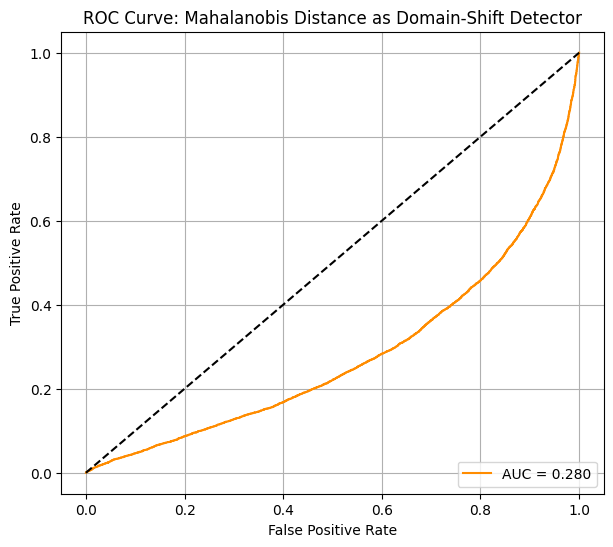

In [23]:
# use distances to create a ROC curve
y_true = np.concatenate([np.zeros_like(dist_clean), np.ones_like(dist_shifted)])
y_score = np.concatenate([dist_clean, dist_shifted])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: Mahalanobis Distance as Domain-Shift Detector")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        class_score = output[:, class_idx]
        class_score.backward()

        # Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])  # shape: [C]
        activations = self.activations.squeeze(0)                     # shape: [C, H, W]

        for i in range(activations.shape[0]):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.sum(activations, dim=0)
        heatmap = torch.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().numpy()


In [16]:
model.features[-3]  # nn.Conv2d(64, 128, ...)

ReLU()

In [17]:
target_layer = model.features[-3]  # You can also use: model.features[6] if it's clearer
gradcam = GradCAM(model, target_layer)


In [18]:
import cv2

def show_gradcam_on_image(img_tensor, heatmap, alpha=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored[..., ::-1] / 255.0  # BGR to RGB

    overlayed_img = alpha * heatmap_colored + (1 - alpha) * img
    overlayed_img = np.clip(overlayed_img, 0, 1)

    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()


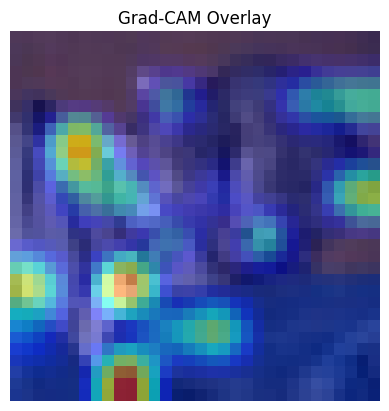

In [19]:
# Get a sample image
sample_img, label = testset_clean[0]
input_tensor = sample_img.unsqueeze(0).to(device)

# Generate Grad-CAM
heatmap = gradcam.generate(input_tensor)

# Show overlay
show_gradcam_on_image(sample_img, heatmap)
